PAPER'S ALGORITHM WITH MANUAL GRADIENT (EQ. 9)
M = 128, N = 4, SNR = 10dB
σ² = 0.02, Adam optimizer lr=1e-3
Using MANUAL gradient computation (Paper Eq. 9)
set seed to 42
Device: cpu, M=128, N=4, SNR=10dB, σ²=0.02
Starting training with MANUAL gradient (Paper Eq. 9)...


Training: 100%|██████████| 1000/1000 [00:14<00:00, 71.05it/s, BER=0.0082, Loss_R=3.880, Loss_T=0.162, σ²=0.0200]


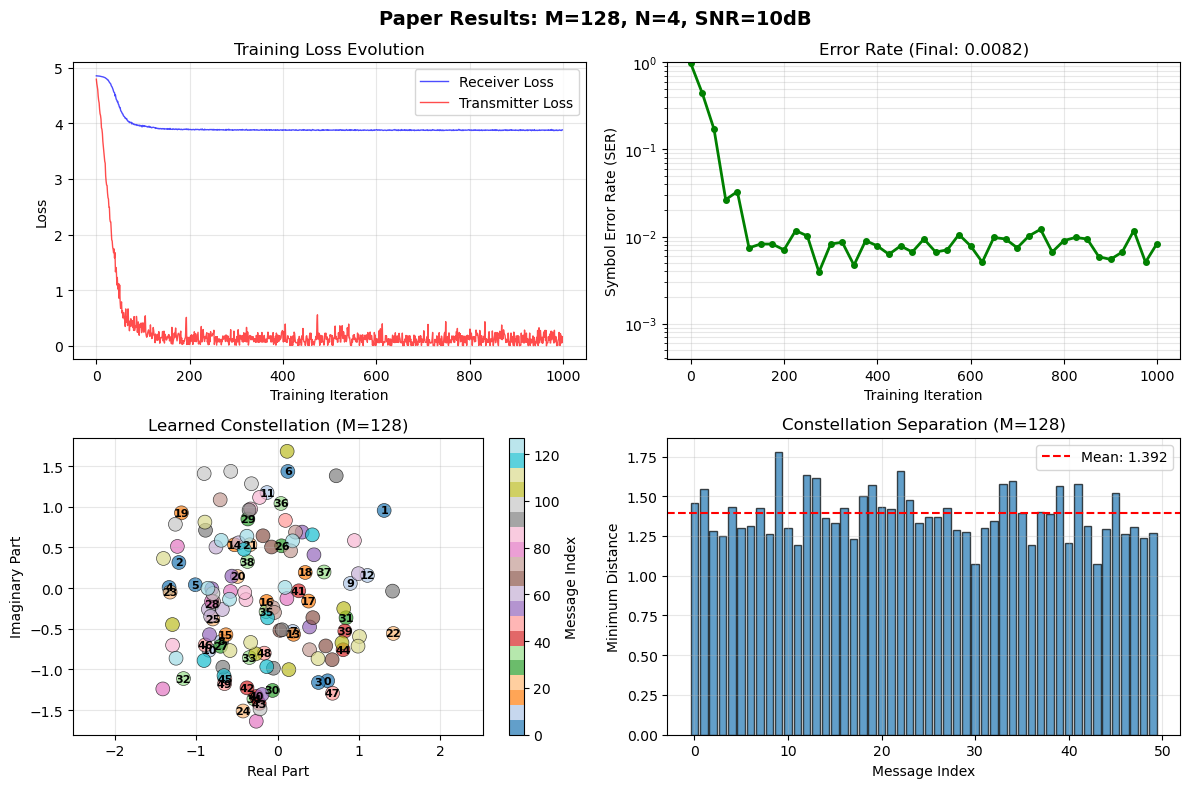


FINAL EVALUATION
Minimum power per symbol: 0.0016
max power per symbol: 3.7020
average power per symbol: 1.0000

Minimum power per message: 1.0000
max power per message: 1.0000
average power per message: 1.0000
Final Symbol Error Rate: 0.007773
Accuracy: 99.22%
Errors: 199 / 25,600 symbols
power/symbol: 1.000000 (doit être ≈ 1.0)
min power: 0.0016, max: 3.7020
Average power: 1.000000 (target: 1.0)

TRAINING WITH MANUAL GRADIENT COMPLETE


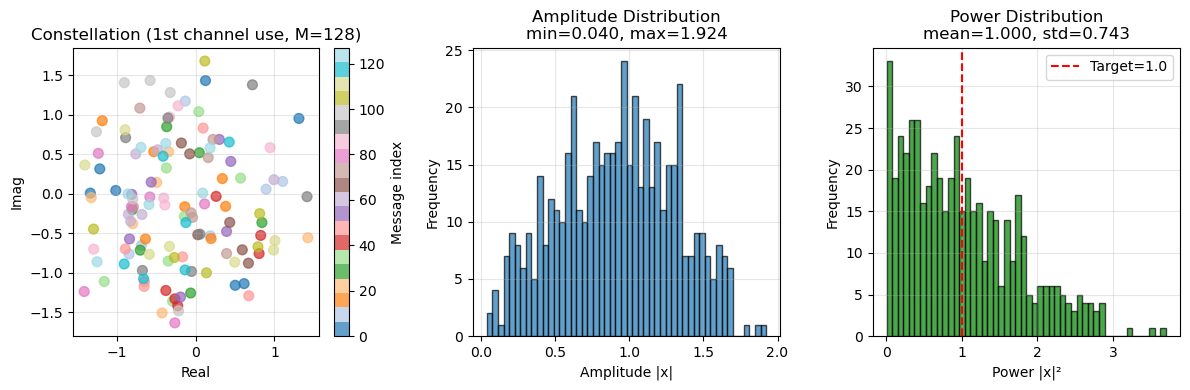


=== Analyse des Distances ===
Distance minimale: 1.0724
Distance moyenne: 1.3918
Distance maximale: 1.8116
Écart-type des distances: 0.1432

=== PAPR (Peak-to-Average Power Ratio) ===
PAPR = 3.702 (5.68 dB)
Typical values:
  - BPSK/QPSK: 0 dB
  - 16-QAM: ~3.5 dB
  - 64-QAM: ~4.5 dB
  - OFDM: 10-12 dB

✓ Constellation bien séparée (min distance > 0.1)

=== Centroid (centre de masse) ===
Channel use 1: -0.201988-0.141290j
Channel use 2: -0.097793+0.068198j
Norme du centroid: 0.180640 (idéalement ≈ 0)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# ====================
# 1. Set seeds 
# ====================
def set_seed(seed=42):

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    print("set seed to",seed)

# ====================
# 2. Helper Functions
# ====================

def complex_to_real(x):
    return torch.view_as_real(x).reshape(*x.shape[:-1], -1)

def real_to_complex(x): 
    return torch.view_as_complex(x.reshape(*x.shape[:-1], -1, 2))

def normalize_power(x):
    # x: (batch_size, N) complex
    # Puissance par exemple: (1/N) * Σ|x_j|²
    power = torch.mean(torch.abs(x) ** 2, dim=1, keepdim=True)  # (batch_size, 1)
    return x / torch.sqrt(power + 1e-8)

def awgn_channel(x, snr_db):
    """AWGN channel as in paper"""
    snr_linear = 10 ** (snr_db / 10) # from db to linear 
    noise_power = 1.0 / snr_linear 
    noise = torch.randn_like(x) * np.sqrt(noise_power / 2)
    return x + noise

# ====================
# 3. Neural Networks 
# ====================
class Transmitter(nn.Module):
    def __init__(self, M=256, N=4):
        super().__init__()
        self.M = M
        self.N = N
        
      
        # M×M embedding with ELU activation functions
        self.embedding = nn.Sequential(
            nn.Embedding(M, M),  # M×M embedding
            nn.ELU()             # ELU activation
        )
        
        # dense layer of 2N units with linear activations
        self.fc = nn.Linear(M, 2 * N)  
        
        
        
    def forward(self, m):
        # Embedding + ELU
        x = self.embedding(m)  # (batch_size, M)
        
        # dense linear 
        x = self.fc(x)  # (batch_size, 2N)
        
        # real to complex

        x = torch.view_as_complex(x.reshape(-1, self.N, 2))
        
        return normalize_power(x)
      

        

class Receiver(nn.Module):
    def __init__(self, M=16, N=4, hidden_size=256):
        super().__init__()
        self.M = M
        self.N = N
        # For AWGN, single dense layer with M units and ReLU
        self.net = nn.Sequential(
            nn.Linear(2 * N, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, M),
            nn.Softmax(dim=1)
        )
        
    def forward(self, y):
        # y: (batch_size, N) complex
        x_real = complex_to_real(y)  # (batch_size, 2N)
        return self.net(x_real)



# ====================
# 4. Training Functions 
# ====================

def train_receiver(transmitter, receiver, optimizer_R, channel_fn, snr_db, 
                  batch_size=256, seed_offset=0):
    
    transmitter.eval()
    receiver.train()
    
    device = next(transmitter.parameters()).device
    
    # Generate messages with seed for reproducibility
    torch.manual_seed(seed_offset + hash("receiver") % 10000)
    m = torch.randint(0, receiver.M, (batch_size,)).to(device)
    
    with torch.no_grad():
        x = transmitter(m)
        y = channel_fn(x, snr_db)
    
    p = receiver(y)
    loss = nn.functional.cross_entropy(p, m)
    
    optimizer_R.zero_grad()
    loss.backward()
    optimizer_R.step()
    
    return loss.item()

  
def train_transmitter(transmitter, receiver, optimizer_T, channel_fn, snr_db,
                          sigma_pi_sq=0.02, batch_size=256, seed_offset=0):
    
    transmitter.train()
    receiver.eval()
    
    device = next(transmitter.parameters()).device
    
    # Generate msg
    torch.manual_seed(seed_offset + hash("transmitter") % 10000)
    m = torch.randint(0, receiver.M, (batch_size,)).to(device)
    
    
    x_det = transmitter(m)  # (batch_size, N) complex
    
    # Exploration 
    scale = np.sqrt(1 - sigma_pi_sq) 
    noise_std = np.sqrt(sigma_pi_sq / 2)
    
    
    noise_real = torch.randn_like(x_det.real) * noise_std
    noise_imag = torch.randn_like(x_det.imag) * noise_std
    w = torch.complex(noise_real, noise_imag)
    
    # x_p 
    x_p = scale * x_det + w
    
    
    with torch.no_grad():
        y = channel_fn(x_p, snr_db)
        p = receiver(y)
        losses = -torch.log(p[torch.arange(batch_size).to(device), m] + 1e-8)
    
    # gradient 
    
    mu = scale * x_det
    
    
    w_vec = x_p - mu
    
   
    w_real = torch.view_as_real(w_vec).reshape(batch_size, -1)  # (batch_size, 2N)
    x_det_real = torch.view_as_real(x_det).reshape(batch_size, -1)  # (batch_size, 2N)
    
    
    
    dot_products = torch.sum(w_real * x_det_real, dim=1)
    
    
    scale_factor = 2 * scale / sigma_pi_sq
    
    
    surrogate_loss = scale_factor * torch.mean(losses.detach() * dot_products)
    
    
    optimizer_T.zero_grad()
    surrogate_loss.backward()
    
    
    
    optimizer_T.step()
    
    return torch.mean(losses).item()



# ====================
# 5. Main Training Loop
# ====================

def alternating_training_paper(M=16, N=4, snr_db=10, sigma_pi_sq=0.02,
                              iterations=500, lr=1e-3, seed=42):
    """Paper's alternating training algorithm with MANUAL gradient"""
    set_seed(seed)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device: {device}, M={M}, N={N}, SNR={snr_db}dB, σ²={sigma_pi_sq}")
    
    # Initialize models
    transmitter = Transmitter(M, N).to(device)
    receiver = Receiver(M, N).to(device)
    
    # Adam optimizer 
    optimizer_T = optim.Adam(transmitter.parameters(), lr=lr)
    optimizer_R = optim.Adam(receiver.parameters(), lr=lr)
    
    channel_fn = awgn_channel
    
    losses_R, losses_T = [], []
    ber_history = []
    
    current_sigma_pi_sq = sigma_pi_sq
    
    print("Starting training with MANUAL gradient (Paper Eq. 9)...")
    pbar = tqdm(range(iterations), desc="Training")
    
    for it in pbar:
        seed_offset = seed + it * 1000
        
        # Receiver training
        loss_R_avg = 0
        for step in range(2):
            loss_R = train_receiver(transmitter, receiver, optimizer_R, 
                                   channel_fn, snr_db, seed_offset=seed_offset+step)
            loss_R_avg += loss_R
        loss_R_avg /= 2
        
        # Transmitter training
        loss_T = train_transmitter(transmitter, receiver, optimizer_T,
                                        channel_fn, snr_db, current_sigma_pi_sq,
                                        seed_offset=seed_offset)
        
        losses_R.append(loss_R_avg)
        losses_T.append(loss_T)
        
        # Evaluate BER
        if it % 25 == 0 or it == iterations - 1:
            transmitter.eval()
            receiver.eval()
            
            with torch.no_grad():
                total_errors = 0
                total_symbols = 0
                
                for eval_iter in range(10):
                    torch.manual_seed(seed + 9999 + it * 100 + eval_iter)
                    m_test = torch.randint(0, M, (256,)).to(device)
                    x_test = transmitter(m_test)
                    y_test = channel_fn(x_test, snr_db)
                    p_test = receiver(y_test)
                    pred = torch.argmax(p_test, dim=1)
                    total_errors += torch.sum(pred != m_test).item()
                    total_symbols += m_test.shape[0]
                
                ber = total_errors / total_symbols
                ber_history.append((it, ber))
            
            pbar.set_postfix({
                'BER': f'{ber:.4f}',
                'Loss_R': f'{loss_R_avg:.3f}',
                'Loss_T': f'{loss_T:.3f}',
                'σ²': f'{current_sigma_pi_sq:.4f}'
            })
    
    return transmitter, receiver, losses_R, losses_T, ber_history

# ====================
# 6. Plotting Results (FIXED for complex tensors)
# ====================

def plot_paper_results(transmitter, receiver, losses_R, losses_T, ber_history, M, N, snr_db):
    """Plot results - FIXED for complex tensor handling"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Loss curves
    axes[0, 0].plot(losses_R, 'b-', label='Receiver Loss', alpha=0.7, linewidth=1)
    axes[0, 0].plot(losses_T, 'r-', label='Transmitter Loss', alpha=0.7, linewidth=1)
    axes[0, 0].set_xlabel('Training Iteration')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].set_title('Training Loss Evolution')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. BER evolution
    if ber_history:
        iters, bers = zip(*ber_history)
        axes[0, 1].semilogy(iters, bers, 'g.-', linewidth=2, markersize=8)
        axes[0, 1].set_xlabel('Training Iteration')
        axes[0, 1].set_ylabel('Symbol Error Rate (SER)')
        axes[0, 1].set_title(f'Error Rate (Final: {bers[-1]:.4f})')
        axes[0, 1].grid(True, which='both', alpha=0.3)
        axes[0, 1].set_ylim([max(1e-4, min(bers)*0.1), 1])
    
    # 3. Learned constellation
    device = next(transmitter.parameters()).device
    with torch.no_grad():
        m_all = torch.arange(M).to(device)
        x_all = transmitter(m_all)  # (M, N) complex
        
        # Plot first channel use
        if x_all.shape[1] > 1:
            x_plot = x_all[:, 0]  # First channel use
        else:
            x_plot = x_all.squeeze()
        
        x_np = x_plot.cpu().numpy()
    
    # Scatter plot
    scatter = axes[1, 0].scatter(x_np.real, x_np.imag, s=100, alpha=0.7,
                                 c=range(M), cmap='tab20', edgecolors='black', linewidths=0.5)
    
    # Add message indices (limited)
    for i in range(min(M, 50)):  # at most 50 labels
        axes[1, 0].text(float(x_np.real[i]), float(x_np.imag[i]), f'{i}',
                       fontsize=8, ha='center', va='center', fontweight='bold')
    
    axes[1, 0].set_xlabel('Real Part')
    axes[1, 0].set_ylabel('Imaginary Part')
    axes[1, 0].set_title(f'Learned Constellation (M={M})')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axis('equal')
    plt.colorbar(scatter, ax=axes[1, 0], label='Message Index')
    
    # 4. Pairwise distances 
    with torch.no_grad():
        # complex to real for distance computation
        x_all_real = complex_to_real(x_all)  # (M, 2N) real
        
        # Euclidean distances in 2N-dimensional real space
        distances = torch.cdist(x_all_real, x_all_real, p=2)
        
        # Remove self-distances
        distances = distances + torch.eye(M, device=device) * 1e6
        min_distances = torch.min(distances, dim=1)[0].cpu().numpy()
    
    axes[1, 1].bar(range(min(M, 50)), min_distances[:min(M, 50)], alpha=0.7, edgecolor='black')
    axes[1, 1].axhline(y=np.mean(min_distances), color='r', linestyle='--',
                      label=f'Mean: {np.mean(min_distances):.3f}')
    axes[1, 1].set_xlabel('Message Index')
    axes[1, 1].set_ylabel('Minimum Distance')
    axes[1, 1].set_title(f'Constellation Separation (M={M})')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Paper Results: M={M}, N={N}, SNR={snr_db}dB', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'paper_manual_M{M}_N{N}_SNR{snr_db}.png', dpi=120, bbox_inches='tight')
    plt.show()

# ====================
# 7. Main Execution
# ====================

if __name__ == "__main__":
    
    M = 128 
    N = 4  
    snr_db = 10 # AWGN
    sigma_pi_sq = 0.02
    iterations = 1000
    
    print("="*60)
    print("PAPER'S ALGORITHM WITH MANUAL GRADIENT (EQ. 9)")
    print("="*60)
    print(f"M = {M}, N = {N}, SNR = {snr_db}dB")
    print(f"σ² = {sigma_pi_sq}, Adam optimizer lr=1e-3")
    print("Using MANUAL gradient computation (Paper Eq. 9)")
    print("="*60)
    
    # Run training
    transmitter, receiver, losses_R, losses_T, ber_history = alternating_training_paper(
        M=M, N=N, snr_db=snr_db, sigma_pi_sq=sigma_pi_sq,
        iterations=iterations, lr=1e-3, seed=42
    )
    
    # Plot results
    plot_paper_results(transmitter, receiver, losses_R, losses_T, ber_history, M, N, snr_db)
    
    # Final evaluation
    print("\n" + "="*60)
    print("FINAL EVALUATION")
    print("="*60)
    
    device = next(transmitter.parameters()).device
    with torch.no_grad():
        m_all = torch.arange(M).to(device)
        x_all = transmitter(m_all)  # Tous les symboles
    
    
        power_per_symbol = torch.abs(x_all) ** 2
        print(f"Minimum power per symbol: {torch.min(power_per_symbol):.4f}")
        print(f"max power per symbol: {torch.max(power_per_symbol):.4f}")
        print(f"average power per symbol: {torch.mean(power_per_symbol):.4f}")
    
    
        power_per_message = torch.mean(power_per_symbol, dim=1)
        print(f"\nMinimum power per message: {torch.min(power_per_message):.4f}")
        print(f"max power per message: {torch.max(power_per_message):.4f}")
        print(f"average power per message: {torch.mean(power_per_message):.4f}")
    
    with torch.no_grad():
        transmitter.eval()
        receiver.eval()
        
        total_errors = 0
        total_symbols = 0
        
        for i in range(50):
            torch.manual_seed(123456 + i)
            m_test = torch.randint(0, M, (512,)).to(device)
            x_test = transmitter(m_test)
            y_test = awgn_channel(x_test, snr_db)
            p_test = receiver(y_test)
            pred = torch.argmax(p_test, dim=1)
            total_errors += torch.sum(pred != m_test).item()
            total_symbols += m_test.shape[0]
        
        final_ser = total_errors / total_symbols
        accuracy = (1 - final_ser) * 100
    
    print(f"Final Symbol Error Rate: {final_ser:.6f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Errors: {total_errors:,} / {total_symbols:,} symbols")


    with torch.no_grad():
        m_test = torch.randint(0, M, (1000,)).to(device)
        x_test = transmitter(m_test)
    
    
        energy = torch.mean(torch.abs(x_test) ** 2)
        print(f"power/symbol: {energy:.6f} (doit être ≈ 1.0)")
    
    # Pas de variations extrêmes
        min_power = torch.min(torch.abs(x_test) ** 2)
        max_power = torch.max(torch.abs(x_test) ** 2)
        print(f"min power: {min_power:.4f}, max: {max_power:.4f}")
    
    # Check power constraint
    with torch.no_grad():
        torch.manual_seed(999)
        m_test = torch.randint(0, M, (5000,)).to(device)
        x_test = transmitter(m_test)
        avg_power = torch.mean(torch.abs(x_test) ** 2).item()
        print(f"Average power: {avg_power:.6f} (target: 1.0)")
    
    print("\n" + "="*60)
    print("TRAINING WITH MANUAL GRADIENT COMPLETE")
    print("="*60)

def plot_constellation_analysis(transmitter, M, N, device):
    
    with torch.no_grad():
        m_all = torch.arange(M).to(device)
        x_all = transmitter(m_all)  # (M, N) complex
        
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        x_np = x_all[:, 0].cpu().numpy()
        scatter = plt.scatter(x_np.real, x_np.imag,
                            c=range(M), cmap='tab20', s=50, alpha=0.7)
        plt.colorbar(scatter, label='Message index')
        plt.xlabel('Real')
        plt.ylabel('Imag')
        plt.title(f'Constellation (1st channel use, M={M})')
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        
        
        plt.subplot(1, 3, 2)
        amplitudes_tensor = torch.abs(x_all).flatten()
        amplitudes_np = amplitudes_tensor.cpu().numpy()
        plt.hist(amplitudes_np, bins=50, alpha=0.7, edgecolor='black')
        plt.xlabel('Amplitude |x|')
        plt.ylabel('Frequency')
        plt.title(f'Amplitude Distribution\nmin={amplitudes_np.min():.3f}, max={amplitudes_np.max():.3f}')
        plt.grid(True, alpha=0.3)
        
        
        plt.subplot(1, 3, 3)
        powers_tensor = torch.abs(x_all) ** 2
        powers_flat = powers_tensor.flatten()
        powers_np = powers_flat.cpu().numpy()
        plt.hist(powers_np, bins=50, alpha=0.7, edgecolor='black', color='green')
        plt.axvline(x=1.0, color='r', linestyle='--', label='Target=1.0')
        plt.xlabel('Power |x|²')
        plt.ylabel('Frequency')
        plt.title(f'Power Distribution\nmean={powers_np.mean():.3f}, std={powers_np.std():.3f}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        
        x_real = torch.view_as_real(x_all).reshape(M, -1)
        distances = torch.cdist(x_real, x_real, p=2)
        distances = distances + torch.eye(M, device=device) * 1e6  # Ignore diagonal
        min_distances = torch.min(distances, dim=1)[0]
        
        print(f"\n=== Analyse des Distances ===")
        print(f"Distance minimale: {torch.min(min_distances):.4f}")
        print(f"Distance moyenne: {torch.mean(min_distances):.4f}")
        print(f"Distance maximale: {torch.max(min_distances):.4f}")
        print(f"Écart-type des distances: {torch.std(min_distances):.4f}")
        
        # 5. PAPR (Peak-to-Average Power Ratio) 
        max_power = torch.max(powers_flat)
        mean_power = torch.mean(powers_flat)
        papr = max_power / mean_power
        
        print(f"\n=== PAPR (Peak-to-Average Power Ratio) ===")
        print(f"PAPR = {papr.item():.3f} ({10*torch.log10(papr).item():.2f} dB)")
        print("Typical values:")
        print("  - BPSK/QPSK: 0 dB")
        print("  - 16-QAM: ~3.5 dB")
        print("  - 64-QAM: ~4.5 dB")
        print("  - OFDM: 10-12 dB")
        
        # check if distance >0
        if torch.min(min_distances) > 0.1:
            print(f"\n✓ Constellation bien séparée (min distance > 0.1)")
        else:
            print(f"\n⚠ Attention: certaines distances sont très petites")
            
        # symetry
        centroid = torch.mean(x_all, dim=0)
        print(f"\n=== Centroid (centre de masse) ===")
        print(f"Channel use 1: {centroid[0]:.6f}")
        print(f"Channel use 2: {centroid[1]:.6f}" if N > 1 else "")
        print(f"Norme du centroid: {torch.abs(centroid).mean():.6f} (idéalement ≈ 0)")


plot_constellation_analysis(transmitter, M, N, device)